My own notebook to play around with the [did](https://github.com/bcallaway11/did) package by Brantly Callaway and Pedro H.C. Sant’Anna. See the vignette [Getting Started with the did Package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html).

Still very much work in progress!

Notes
 - Used conda environment in the notebook is `dev2023a` from [here](https://github.com/vvoutilainen/dsenvs/blob/main/condaenv.md). *did* package was installed by:
   - First installing *r-ggpubr* to `dev2023a` via conda/mamba. This also downloaded packages *r-pbkrtest*, *r-car*, *r-rstatix*
   - Next, *did* was installed using R's `install.packages()` command with `dependencies=TRUE`. This also installed a few additional packages (*trust*, *BMisc*, *pbapply* , *DRDID*).
 - Repeated cross-section can be created by using `panel=FALSE` in function `build_sim_dataset`.
 - By default, the did package uses the group of units that never participate in the treatment as the control group. The "not yet treated" include the never treated as well as those units that, for a particular point in time, have not been treated yet (though they eventually become treated).
 
Questions

 - How is `G` in data used? Why does "never-treated" get `G=0`? I guess the point is that zeroeth period does not exist in the period column and this is why it is assigned as the "time of treatment" for the control group. Check! 

In [1]:
%%capture
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(did)
set.seed(1814)

In [3]:
def plot_group_means(df):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 1, 1)
    _ = df.groupby([
        "G",
        "period",
    ]).agg({"Y": "mean"}).reset_index().pivot_table(
        values="Y",
        index="period",
        columns="G"
    ).plot(
        style='.--',
        ax=ax,
    )

def plot_group_cluster_means(df):
    fig = plt.figure(figsize=(8, 4))
    for counter, g in enumerate(df["G"].unique()):
        ax = fig.add_subplot(2, 2, counter+1)
        df.query("G=={}".format(g)).groupby([
            "cluster",
            "period",
        ]).agg({"Y": "mean"}).reset_index().pivot_table(
            values="Y",
            index="period",
            columns="cluster"
        ).plot(
            style='.--',
            legend=False,
            linewidth=0.5,
            markersize=2,
            ax=ax,
        )
        ax.set_title("G = {}".format(g))
    fig.tight_layout()

## Panel data

### Example with vanilla panel two-group, two-period case

In [4]:
%%R -o dta
sp = reset.sim(time.periods=2)
dta = build_sim_dataset(sp)
dta = subset(dta, select = -c(cluster) )

Length of data frame
Number of unique observations per id: [2]


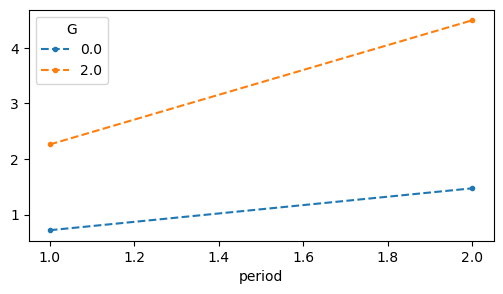

In [5]:
print("Length of data frame".format(len(dta)))
print("Number of unique observations per id: {}".format(
    dta.groupby(["id"]).agg({"Y": "count"}).loc[:, "Y"].unique()
))
plot_group_means(dta)

In [6]:
# Build model in statsmodels
dta["period_dummy"] = np.where(dta["period"] < 2, 0, 1)
dta["periodxtreatment_dummy"] = dta["period_dummy"] * dta["treat"]
reg_str = "Y ~ 1 + treat + period_dummy + periodxtreatment_dummy"
res = smf.ols(reg_str, data=dta).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": dta["id"],
        "use_correction": False,
    }
)
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + treat + period_dummy + periodxtreatment_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1255.
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        16:05:23   Log-Likelihood:                -14822.
No. Observations:                6690   AIC:                         2.965e+04
Df Residuals:                    6686   BIC:                         2.968e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [7]:
%%R -i dta
# Repeat using did package, same result
# Warning relates to Wald pre-treatment period test 
out = att_gt(
    yname="Y",
    tname="period",,
    idname="id",
    gname="G",
    bstrap=F,
    panel=T,
    data=dta,
)
summary(out)

R[write to console]: No pre-treatment periods to test




Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    data = dta, panel = T, bstrap = F)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     2    2   1.4811     0.0596          1.3643      1.5979 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


### Example from the vignette

In [8]:
%%R -o dta,sp
sp = reset.sim()
time_periods = 4
sp$te.e <- 1:time_periods
dta = build_sim_dataset(sp)

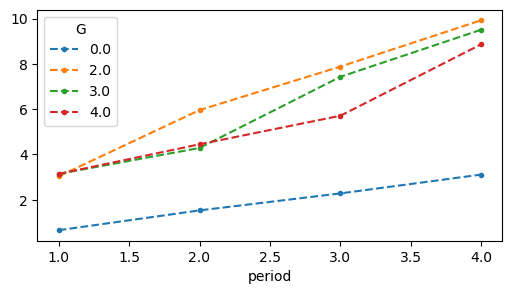

In [9]:
plot_group_means(dta)

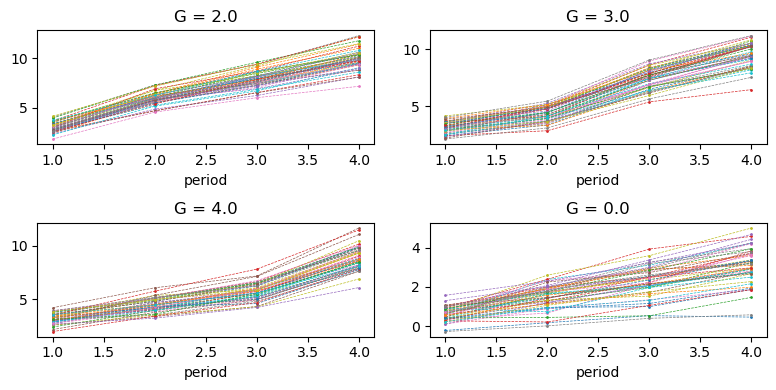

In [10]:
plot_group_cluster_means(dta)

In [11]:
%%R
# Control group never treated
attgt_1 = att_gt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla=~X,
    control_group="notyettreated",
    data=dta
)

# Control group never treated + not yet treated
attgt_2 = att_gt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla=~X,
    control_group="nevertreated",
    data=dta
)

# Aggregate over groups
agg_simple_1 = aggte(attgt_1, type="simple")
agg_dynamic_1 = aggte(attgt_1, type="dynamic")
agg_group_1 = aggte(attgt_1, type="group")

agg_simple_2 = aggte(attgt_2, type="simple")
agg_dynamic_2 = aggte(attgt_2, type="dynamic")
agg_group_2 = aggte(attgt_2, type="group")

In [12]:
%%R
summary(agg_simple_1)
summary(agg_simple_2)


Call:
aggte(MP = attgt_1, type = "simple")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


    ATT    Std. Error     [ 95%  Conf. Int.]  
 2.5689        0.0342     2.5018      2.6359 *


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Not Yet Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust

Call:
aggte(MP = attgt_2, type = "simple")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


    ATT    Std. Error     [ 95%  Conf. Int.]  
 2.5752        0.0357     2.5053      2.6451 *


---
Signif. codes: `*' confidence band does not 


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, control_group = "nevertreated")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   1.8506     0.0628        1.6764      2.0249 *
     2    3   2.8229     0.0613        2.6527      2.9930 *
     2    4   3.8488     0.0598        3.6830      4.0146 *
     3    2  -0.0771     0.0654       -0.2584      0.1042  
     3    3   2.0610     0.0616        1.8903      2.2318 *
     3    4   2.9936     0.0647        2.8141      3.1730 *
     4    2  -0.0275     0.0636       -0.2040      0.1489  
     4    3   0.0706     0.0679       -0.1179      0.2590  
     4    4   1.9048     0

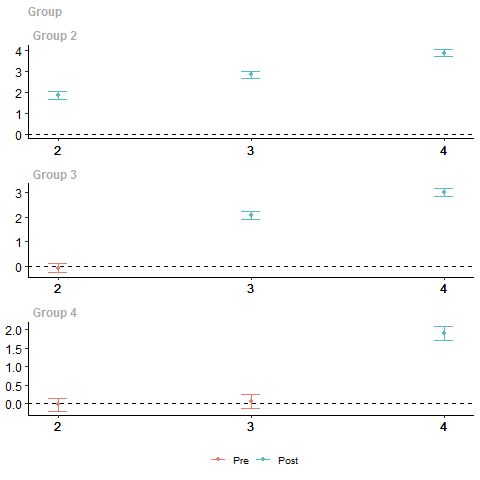

In [13]:
%%R
summary(attgt_2)
ggdid(attgt_2)


Call:
aggte(MP = attgt_2, type = "dynamic")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
 ATT    Std. Error     [ 95%  Conf. Int.]  
 2.9        0.0391     2.8234      2.9766 *


Dynamic Effects:
 Event time Estimate Std. Error [95% Simult.  Conf. Band]  
         -2  -0.0275     0.0697       -0.2071      0.1520  
         -1  -0.0039     0.0381       -0.1021      0.0943  
          0   1.9406     0.0319        1.8585      2.0227 *
          1   2.9105     0.0445        2.7960      3.0250 *
          2   3.8488     0.0624        3.6881      4.0095 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


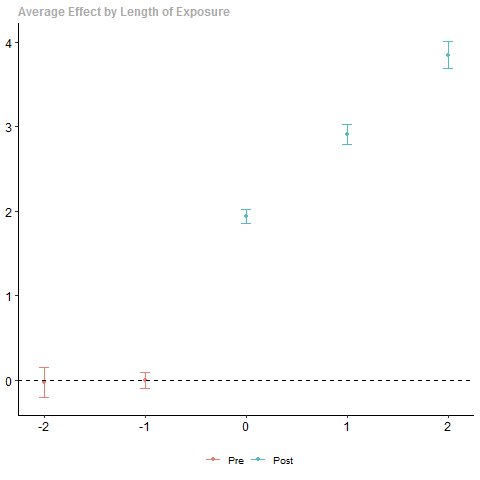

In [14]:
%%R
summary(agg_dynamic_2)
ggdid(agg_dynamic_2)


Call:
aggte(MP = attgt_2, type = "group")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on group/cohort aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.]  
 2.4198        0.0338     2.3534      2.4861 *


Group Effects:
 Group Estimate Std. Error [95% Simult.  Conf. Band]  
     2   2.8408     0.0505        2.7210      2.9606 *
     3   2.5273     0.0624        2.3793      2.6753 *
     4   1.9048     0.0669        1.7462      2.0634 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


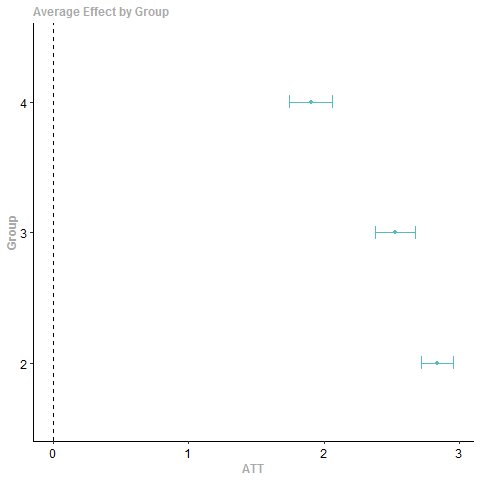

In [15]:
%%R
summary(agg_group_2)
ggdid(agg_group_2)

## Repeated cross section

### Example with *did* simulated wanilla two-group, two-period case

In [16]:
%%R -o dta
sp = reset.sim(time.periods=2)
dta = build_sim_dataset(sp, panel=FALSE)
dta = subset(dta, select = -c(cluster) )

Length of data frame
Number of unique observations per id: [1]


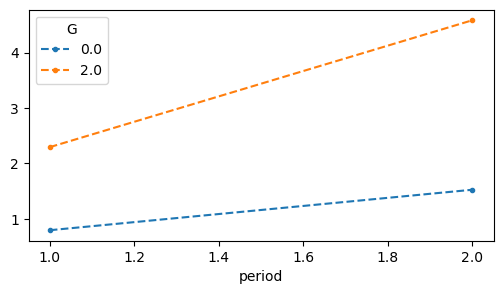

In [17]:
print("Length of data frame".format(len(dta)))
print("Number of unique observations per id: {}".format(
    dta.groupby(["id"]).agg({"Y": "count"}).loc[:, "Y"].unique()
))
plot_group_means(dta)

In [18]:
# Build model in statsmodels
dta["period_dummy"] = np.where(dta["period"] < 2, 0, 1)
dta["periodxtreatment_dummy"] = dta["period_dummy"] * dta["treat"]
reg_str = "Y ~ 1 + treat + period_dummy + periodxtreatment_dummy"
res = smf.ols(reg_str, data=dta).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": dta["id"],
        "use_correction": False,
    }
)
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + treat + period_dummy + periodxtreatment_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     463.6
Date:                Mon, 15 May 2023   Prob (F-statistic):          4.13e-252
Time:                        16:05:33   Log-Likelihood:                -7356.8
No. Observations:                3367   AIC:                         1.472e+04
Df Residuals:                    3363   BIC:                         1.475e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [19]:
%%R -i dta
# Repeat using did package, same result
# Warning relates to Wald pre-treatment period test 
out = att_gt(
    yname="Y",
    tname="period",
    gname="G",
    bstrap=F,
    panel=F,
    data=dta,
)
summary(out)

R[write to console]: No pre-treatment periods to test




Call:
att_gt(yname = "Y", tname = "period", gname = "G", data = dta, 
    panel = F, bstrap = F)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     2    2   1.5611     0.1474          1.2722      1.8499 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


### Example with my own simulated multi-period, two-group case

In [20]:
def simulate_data(
    tau,
    b_c,
    b_t,
    mu_gc_c,
    sigma_gc_c,
    mu_gc_t,
    sigma_gc_t,
    mu_tgc_c,
    sigma_tgc_c,
    mu_tgc_t,
    sigma_tgc_t,
    **kwargs,
):
    
    # Optional parameters
    no_periods = kwargs.get("no_periods", 6)
    last_pre_timepoint = kwargs.get("last_pre_timepoint", 2) 
    no_obs = kwargs.get("no_obs", 300)     
    
    for t in range(no_periods):

        common_random_trend_deviation = np.abs(np.random.random())

        # Control group
        df_t = pd.DataFrame(np.random.random(size=no_obs), columns=["Y"]) + b_c * t * common_random_trend_deviation

        # Group confounding for control
        df_t["GC"] = np.random.normal(loc=mu_gc_c, scale=sigma_gc_c, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["GC"]

        # Time confounding for control
        if t >= last_pre_timepoint:
            df_t["TGC"] = np.random.normal(loc=mu_tgc_c, scale=sigma_tgc_c, size=no_obs)
            df_t["Y"] = df_t["Y"] + df_t["TGC"]
        else:
            df_t["TGC"] = np.random.normal(loc=0, scale=sigma_tgc_c, size=no_obs)
            df_t["Y"] = df_t["Y"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            control = df_t
        else:
            #control = control.append(df_t, ignore_index=True)
            control = pd.concat([control, df_t], ignore_index=True)

        # Treatment group
        df_t = pd.DataFrame(np.random.random(size=no_obs), columns=["Y"]) + b_t * t * common_random_trend_deviation

        # Group confounding for treatment
        df_t["GC"] = np.random.normal(loc=mu_gc_t, scale=sigma_gc_t, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["GC"]

        # Time confounding for treatment
        df_t["TGC"] = np.random.normal(loc=mu_tgc_t, scale=sigma_tgc_t, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            treatment_cf = df_t
        else:
            #treatment_cf = treatment_cf.append(df_t, ignore_index=True)
            treatment_cf = pd.concat([treatment_cf, df_t], ignore_index=True)

    treatment_cf["time_group"] = np.where(treatment_cf["t"] > last_pre_timepoint, "after", "before")
    control["time_group"] = np.where(control["t"] > last_pre_timepoint, "after", "before")
    treatment_cf["tc_group"] = "treatment"
    control["tc_group"] = "control"

    treatment = treatment_cf.copy()
    treatment.loc[treatment["time_group"] == "after", "Y"] = treatment.loc[treatment["time_group"] == "after", "Y"] + tau

    # Save mean values
    means = {}
    means["control_before"] = control.query("time_group == 'before'")["Y"].mean()
    means["control_after"] = control.query("time_group == 'after'")["Y"].mean()
    means["treatment_before"] = treatment.query("time_group == 'before'")["Y"].mean()
    means["treatment_after"] = treatment.query("time_group == 'after'")["Y"].mean()
    means["treatment_cf_before"] = treatment_cf.query("time_group == 'before'")["Y"].mean()
    means["treatment_cf_after"] = treatment_cf.query("time_group == 'after'")["Y"].mean()
    for t in range(no_periods):
        means["control_t" + str(t)] = control.query("t == {}".format(t))["Y"].mean()
        means["treatment_t" + str(t)] = treatment.query("t == {}".format(t))["Y"].mean()
        means["treatment_cf_t" + str(t)] = treatment_cf.query("t == {}".format(t))["Y"].mean()
        
    return {"treatment": treatment, "control": control, "treatment_cf": treatment_cf, "means": means}

colors = [
    "#003f5c",
    "#2f4b7c",
    "#665191",
    "#a05195",
    "#d45087",
    "#f95d6a",
    "#ff7c43",
    "#ffa600",
]

def plot_data(data, **kwargs):

    no_periods = kwargs.get("no_periods", 6)
    last_pre_timepoint = kwargs.get("last_pre_timepoint", 2)

    treatment = data["treatment"]
    control = data["control"]
    treatment_cf = data["treatment_cf"]
    means = data["means"]

    time_fe_mean_line_pos = [(0, 0.1), (0.175, 0.275), (0.375, 0.475), (0.55, 0.65), (0.75, 0.825), (0.90, 1)]
    def format_ax(ax):
        ax.set_ylabel("Y")
        ax.axvline(2.5, linestyle="-", c=colors[0], linewidth=2)
        #ax.set_ylim(-4, 10)
        ax.legend()

    fig = plt.figure(figsize=(14, 10))

    ax = fig.add_subplot(2, 1, 1)
    control.plot.scatter(x="t", y="Y", ax=ax, s=1, c=colors[3], label="Realized observations")
    ax.axhline(y=means["control_before"], xmin=0, xmax=0.5, linestyle="--", c=colors[3], label="Realized pre/post-period means and individual time-point means")
    ax.axhline(y=means["control_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[3])
    for t, xminmax in zip(range(no_periods), time_fe_mean_line_pos):
        ax.axhline(y=means["control_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", c=colors[3])
    format_ax(ax)
    ax.set_title("Control group")
    ax.set_xlabel(None)

    ax = fig.add_subplot(2, 1, 2)
    # Realized
    treatment.plot.scatter(x="t", y="Y", ax=ax, s=1, c=colors[3], label="Realized observations")
    ax.axhline(y=means["treatment_before"], xmin=0, xmax=0.5, linestyle="--", c=colors[3], label="Realized pre/post-period means and individual time-point means")
    ax.axhline(y=means["treatment_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[3])
    for t, xminmax in zip(range(no_periods), time_fe_mean_line_pos):
        ax.axhline(y=means["treatment_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", c=colors[3])
    # Counterfactual (unobserved)
    treatment_cf.query("time_group == 'after'").plot.scatter(x="t", y="Y", ax=ax, color=colors[6], s=1, label="Counterfactual observations (unobserved)")
    ax.axhline(y=means["treatment_cf_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[6], label="Counterfactual post-period mean (unobserved)")
    for t, xminmax in zip(range(last_pre_timepoint+1, no_periods), time_fe_mean_line_pos[last_pre_timepoint+1:]):
           ax.axhline(y=means["treatment_cf_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", color=colors[6])

    # Counterfactual (estimated)
    ax.axhline(y=means["treatment_before"] + (means["control_after"] - means["control_before"]), xmin=0.5, xmax=1.0,
        linestyle="--", color=colors[4], label="Counterfactual post-period mean (naively estimated)")

    format_ax(ax)
    ax.set_title("Treatment group")
    fig.tight_layout()

    # Prints
    print("Realized control pre-period mean {:.3f}".format(means["control_before"]))
    print("Realized control post-period mean {:.3f}".format(means["control_after"]))
    print("Realized treated pre-period mean {:.3f}".format(means["treatment_before"]))
    print("Realized treated post-period mean {:.3f}".format(means["treatment_after"]))
    print("Counterfactual (unobserved) treatment post-period mean {:.3f}".format(means["treatment_cf_after"]))
    for el1, el2 in zip(["control", "treatment", "treatment_cf"],
        ["Realized control", "Realized treated", "Counterfactual treated (unobserved)"]):
        for t in range(no_periods):
            print("{} t_{} mean {:.3f}".format(
                el2,
                t, 
                means[el1 + "_t" + str(t)],
            ))
    print("Counterfactual (naively estimated) treated post-period mean {:.3f}".format(
        means["treatment_before"] + (means["control_after"] - means["control_before"])))
    print("Naive DiD-estimate {:.3f}".format(
        (means["treatment_after"] - means["treatment_before"]) -
        (means["control_after"] - means["control_before"])
    ))

def parallel_trends_plot(data):
    treatment = data["treatment"].copy()
    control = data["control"].copy()

    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(2, 1, 1)
    treatment.groupby(["t"]).agg({"Y": "mean"}) \
        .rename(columns={"Y": "Treatment group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[3])
    control.groupby(["t"]).agg({"Y": "mean"}) \
        .rename(columns={"Y": "Control group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[5])
    ax.axvline(2.5, c=colors[0])
    ax.set_title("Average Y")

    ax = fig.add_subplot(2, 1, 2)
    treatment.groupby(["t"]).agg({"Y": "mean"}) \
        .subtract(treatment.query("time_group == 'before'").loc[:, "Y"].mean()) \
        .rename(columns={"Y": "Treatment group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[3])
    control.groupby(["t"]).agg({"Y": "mean"}) \
        .subtract(control.query("time_group == 'before'").loc[:, "Y"].mean()) \
        .rename(columns={"Y": "Control group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[5])
    ax.axvline(2.5, c=colors[0])
    ax.set_title("De-meaned (using group's pre-period average) average Y")

    fig.tight_layout()

def prepare_regression_frame(treatment, control):
    df = pd.concat([treatment.copy(), control.copy()], ignore_index=True)
    df["dummy_period"] = df["time_group"].copy().map({"before": 0, "after": 1})
    df["dummy_group"] = df["tc_group"].copy().map({"control": 0, "treatment": 1})
    df["dummy_group_x_period"] = df["dummy_period"] * df["dummy_group"]
    df["t"] = df["t"].astype(str)

    return df

In [21]:
data_1 = simulate_data(
    tau=-2,
    b_c=1,
    b_t=1,
    mu_gc_c=-1,
    sigma_gc_c=1,
    mu_gc_t=1.5,
    sigma_gc_t=1,
    mu_tgc_c=0,
    sigma_tgc_c=1,
    mu_tgc_t=0,
    sigma_tgc_t=1,
)

Realized control pre-period mean 0.252
Realized control post-period mean 2.847
Realized treated pre-period mean 2.886
Realized treated post-period mean 3.482
Counterfactual (unobserved) treatment post-period mean 5.482
Realized control t_0 mean -0.479
Realized control t_1 mean 0.149
Realized control t_2 mean 1.086
Realized control t_3 mean 2.203
Realized control t_4 mean 2.750
Realized control t_5 mean 3.587
Realized treated t_0 mean 2.070
Realized treated t_1 mean 2.830
Realized treated t_2 mean 3.758
Realized treated t_3 mean 2.815
Realized treated t_4 mean 3.630
Realized treated t_5 mean 3.999
Counterfactual treated (unobserved) t_0 mean 2.070
Counterfactual treated (unobserved) t_1 mean 2.830
Counterfactual treated (unobserved) t_2 mean 3.758
Counterfactual treated (unobserved) t_3 mean 4.815
Counterfactual treated (unobserved) t_4 mean 5.630
Counterfactual treated (unobserved) t_5 mean 5.999
Counterfactual (naively estimated) treated post-period mean 5.481
Naive DiD-estimate -1.99

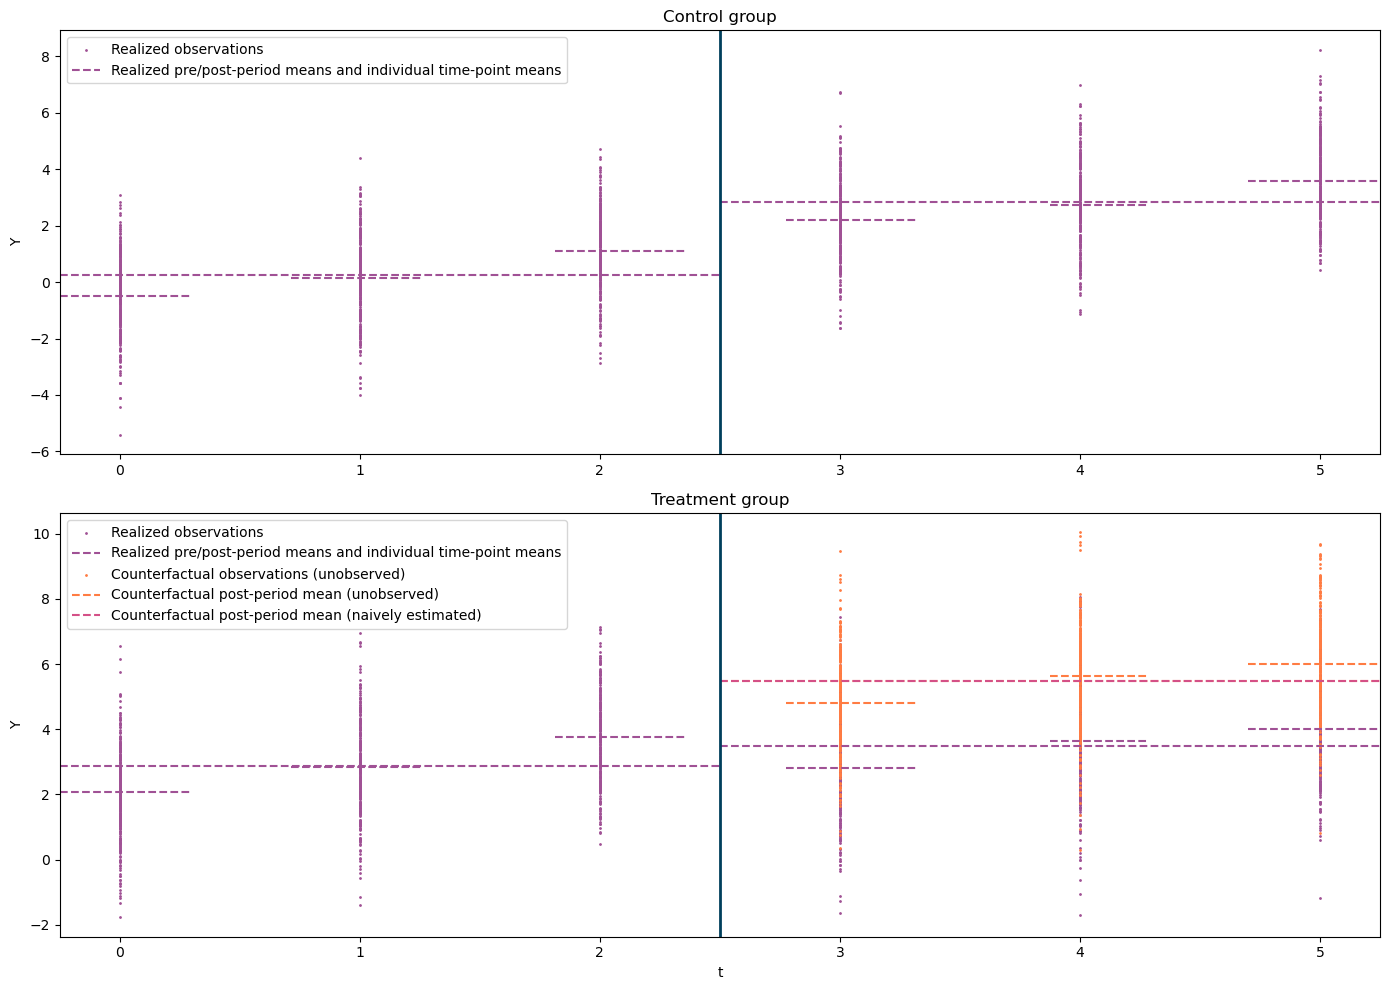

In [22]:
plot_data(data_1)

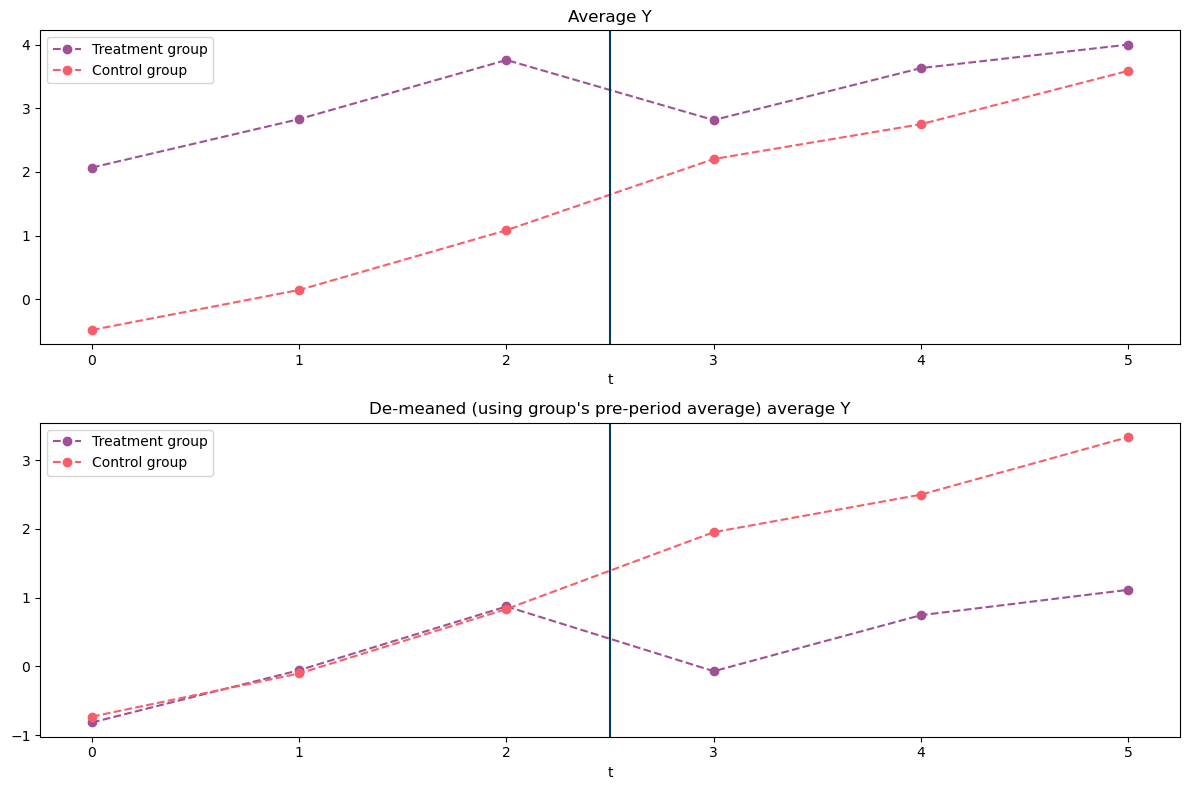

In [23]:
parallel_trends_plot(data_1)

In [24]:
df = prepare_regression_frame(data_1["treatment"], data_1["control"])
df["t"] = (df["t"].astype(int) + 1).astype("object")
df["t_num"] = df["t"].copy().astype(float)
df["tc_group_num"] = df["tc_group"].copy().map({"control": 0, "treatment": 4})
reg_str = "Y ~ -1 + tc_group + t + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     477.8
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        16:05:34   Log-Likelihood:                -6404.9
No. Observations:                3600   AIC:                         1.283e+04
Df Residuals:                    3592   BIC:                         1.288e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
tc_group[control]       -0.5220 

In [25]:
%%R -i df
out = att_gt(
    yname="Y",
    tname="t_num",
    gname="tc_group_num",
    bstrap=F,
    panel=F,
    data=df,
)
agg_simple = aggte(out, type="simple")
summary(out)
summary(agg_simple)


Call:
att_gt(yname = "Y", tname = "t_num", gname = "tc_group_num", 
    data = df, panel = F, bstrap = F)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     4    2   0.1326     0.1634         -0.1877      0.4529  
     4    3  -0.0100     0.1631         -0.3296      0.3097  
     4    4  -2.0602     0.1625         -2.3786     -1.7417 *
     4    5  -1.7915     0.1658         -2.1165     -1.4665 *
     4    6  -2.2595     0.1626         -2.5782     -1.9407 *
---
Signif. codes: `*' confidence band does not cover 0

P-value for pre-test of parallel trends assumption:  0.65505
Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust

Call:
aggte(M